In [18]:
import os
import sys
import csv
import requests
from collections import Counter
from datetime import date
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
## YOUR CODE HERE

from monitoring import get_latest_train_data, get_monitoring_tools

## load latest data
data = get_latest_train_data()
y = data['y']
X = data['X']

In [20]:
## generate some data
bs_samples = 60
subset_indices = np.random.choice(np.arange(X.shape[0]),
                                  bs_samples,replace=True).astype(int)
mask = np.in1d(np.arange(X.shape[0]),subset_indices)
X_bs=X[mask]
X_outliers = X[:5].copy()
X_outliers['age'] = [88,90,76,80,68]
X_outliers['num_streams'] = [111,100,80,90,150]
X_query = pd.concat([X_bs,X_outliers])

print(X_query.shape)

(64, 4)


In [23]:
## delete the log file so we are starting fresh
today = date.today() 
logfile = os.path.join("logs","predict-{}-{}.log".format(today.year, today.month)) 
print(logfile)
if os.path.exists(logfile):
    os.remove(logfile)

## ping the API
request_json = {'query':X_query.to_dict(),'type':'dict'}
port = 8080
r = requests.post('http://localhost:{}/predict'.format(port),json=request_json)
response = literal_eval(r.text)
print(list(sorted(Counter(response['y_pred']).items())))

logs/predict-2020-7.log
[(0.0, 55), (1.0, 9)]


In [24]:
pm_tools = get_monitoring_tools(X,y)

In [25]:
## read in the logged data
df = pd.read_csv(logfile)
df.drop(columns=["unique_id","y_proba"], inplace=True)
df.head()

,timestamp,y_pred,query,model_version,runtime
0,1.595457e+09,0.0,"['united_states', 21, 'aavail_premium', 24]",0.1,000:00:00
1,1.595457e+09,0.0,"['singapore', 44, 'aavail_basic', 17]",0.1,000:00:00
2,1.595457e+09,0.0,"['united_states', 24, 'aavail_unlimited', 6]",0.1,000:00:00
3,1.595457e+09,0.0,"['united_states', 30, 'aavail_basic', 22]",0.1,000:00:00
4,1.595457e+09,0.0,"['united_states', 21, 'aavail_premium', 20]",0.1,000:00:00


In [26]:
## reconstruct a data frame from the logged queries
queries = [literal_eval(q) for q in df['query'].values]
queries = pd.DataFrame(queries)
queries.columns = ['country', 'age', 'subscriber_type', 'num_streams']
print(queries.shape)
queries.head()

(64, 4)


,country,age,subscriber_type,num_streams
0,united_states,21,aavail_premium,24
1,singapore,44,aavail_basic,17
2,united_states,24,aavail_unlimited,6
3,united_states,30,aavail_basic,22
4,united_states,21,aavail_premium,20


OUTLIER TEST FAILED: 9.38 >= 2.1
DISTRIBUTION X TEST FAILED: 0.27 >= 0.02
DISTRIBUTION y TEST FAILED: 0.15 >= 0.04


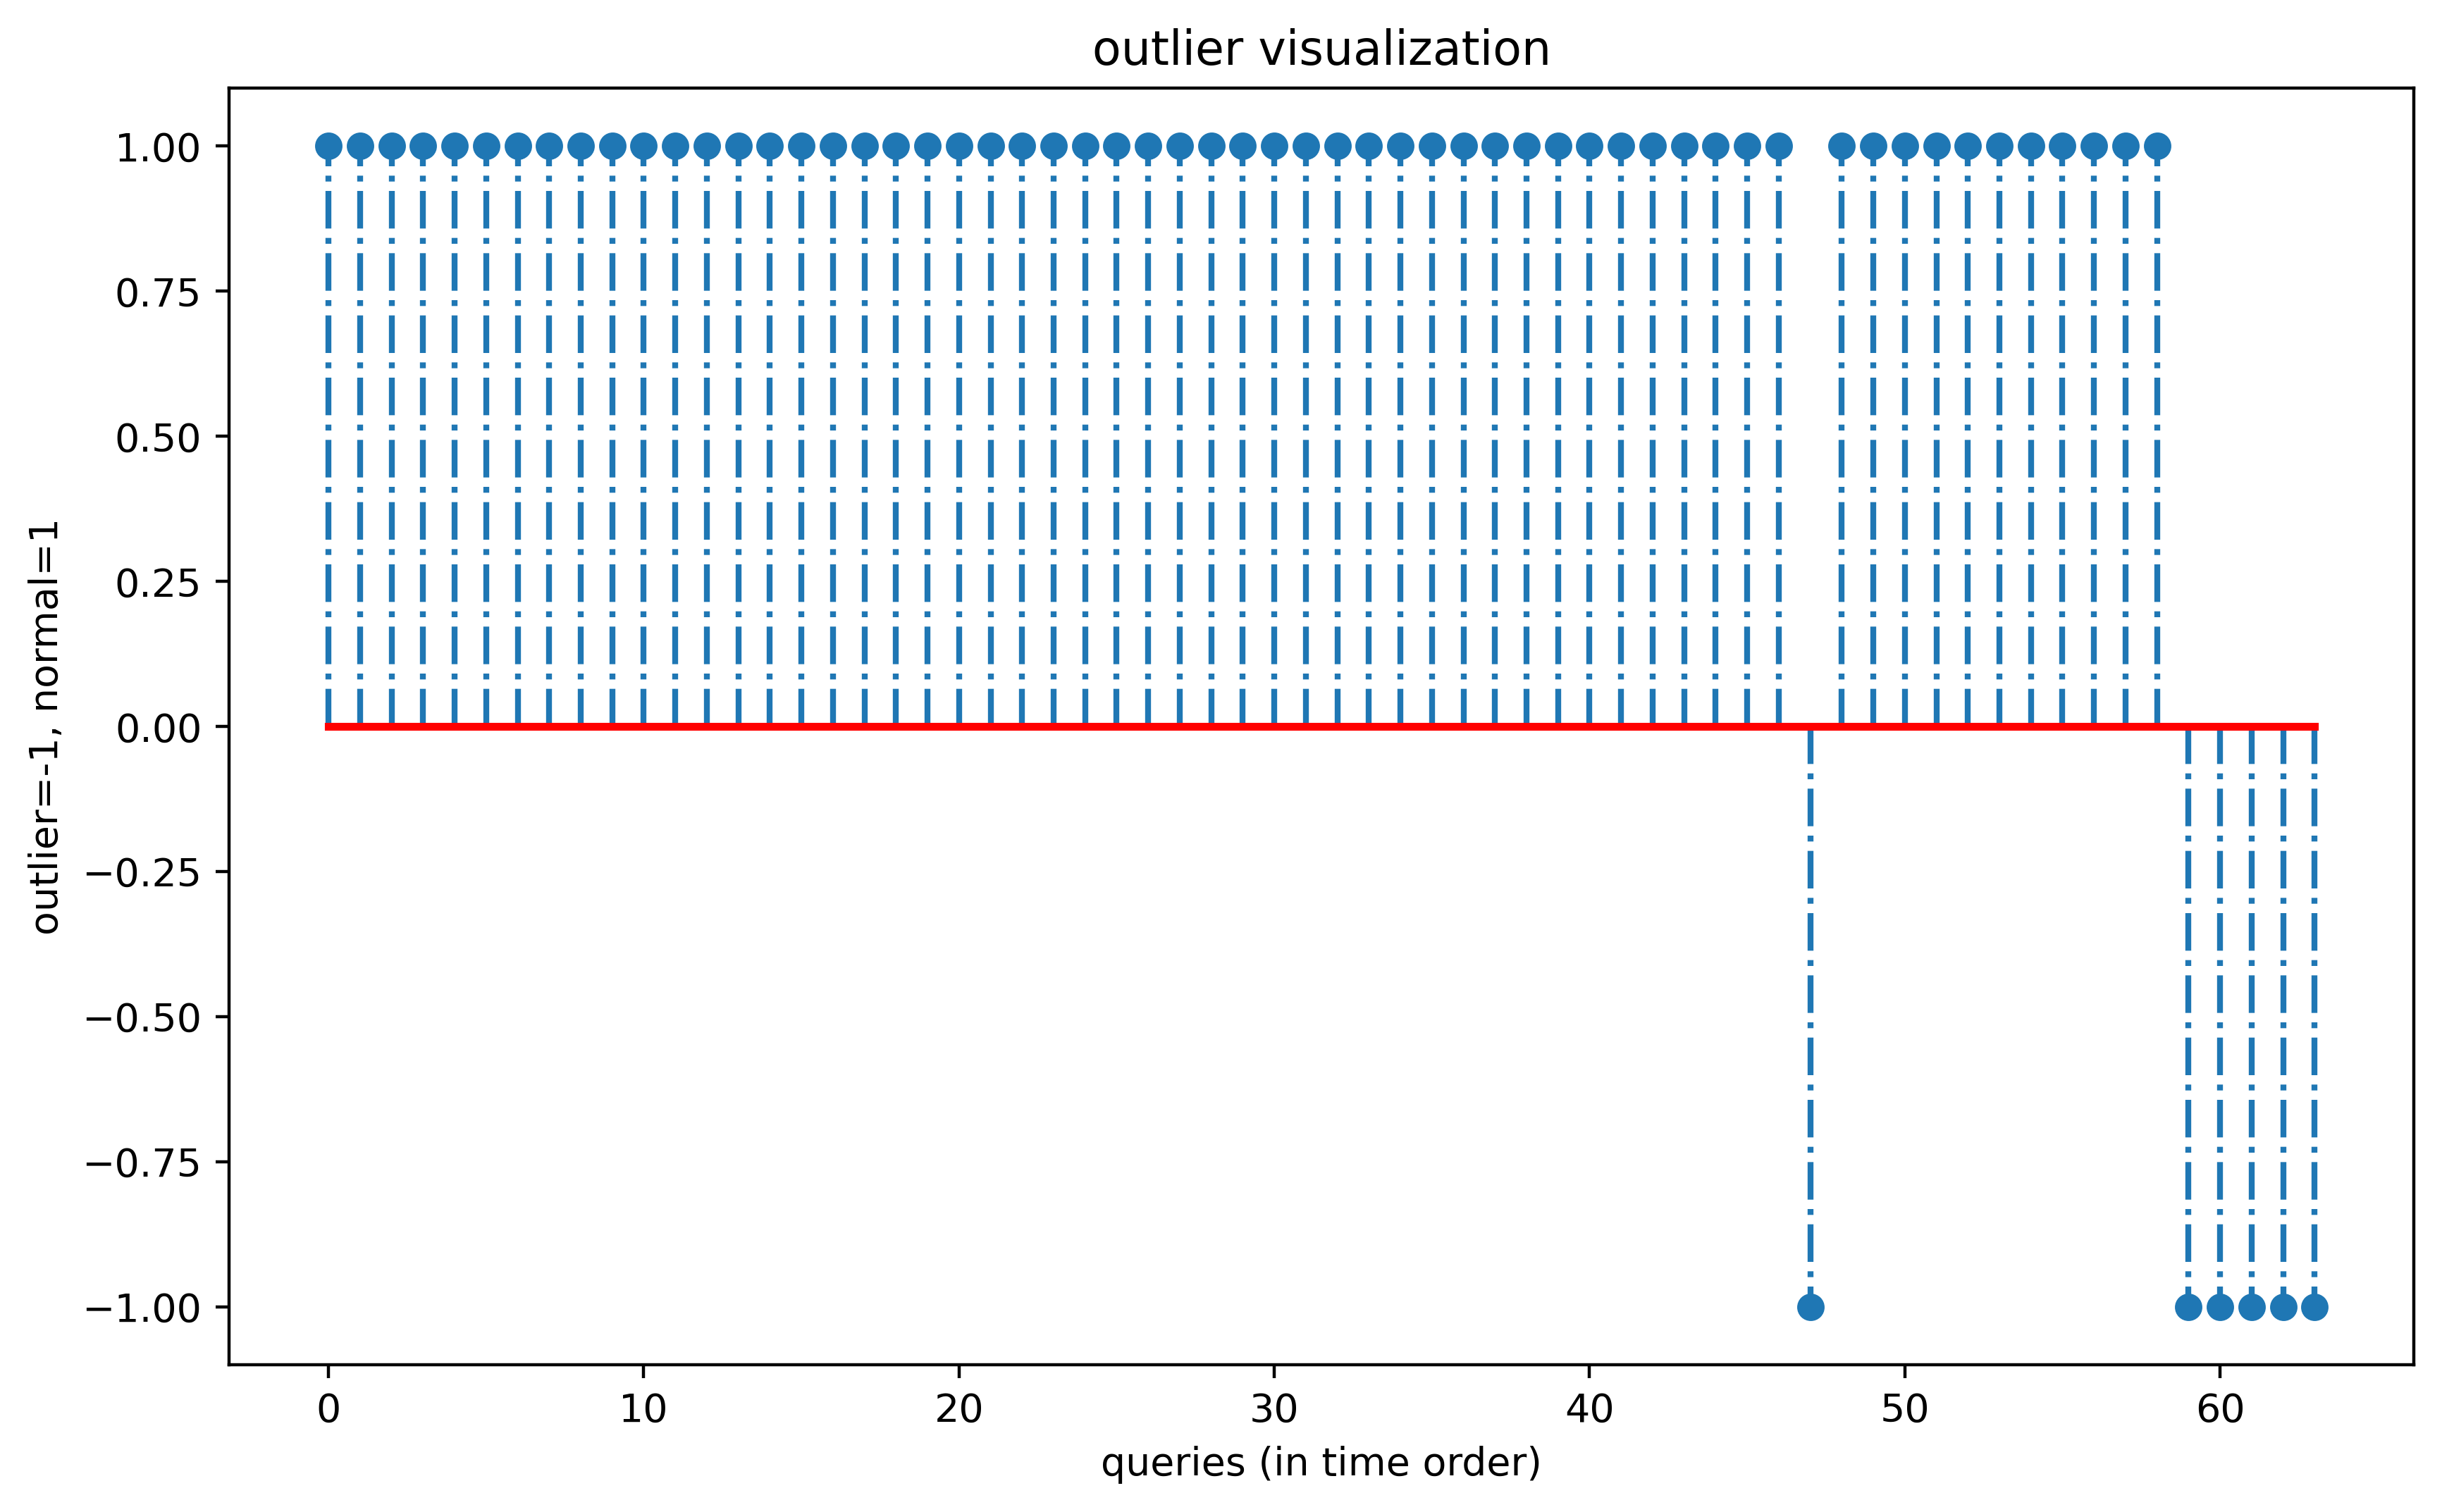

In [27]:
from scipy.stats import wasserstein_distance
X_target = pm_tools['preprocessor'].transform(queries)

outlier_test = pm_tools['clf_X'].predict(X_target)
outliers_X = 100 * (1.0 - (outlier_test[outlier_test==1].size / outlier_test.size))
wasserstein_X = wasserstein_distance(pm_tools['X_source'].flatten(),X_target.flatten()) 
wasserstein_y = wasserstein_distance(pm_tools['y_source'],df['y_pred'].values)

if outliers_X >= pm_tools['outlier_X']:
    print("OUTLIER TEST FAILED: {} >= {}".format(round(outliers_X,2),
                                                 pm_tools['outlier_X']))
else:
    print("OUTLIER TEST PASSED: {} < {}".format(round(outliers_X,2),
                                                pm_tools['outlier_X']))
    
if wasserstein_X >= pm_tools['wasserstein_X']:
    print("DISTRIBUTION X TEST FAILED: {} >= {}".format(round(wasserstein_X,2),
                                                        pm_tools['wasserstein_X']))
else:
    print("DISTRIBUTION X TEST PASSED: {} < {}".format(round(wasserstein_X),
                                                       pm_tools['wasserstein_X']))
    
if wasserstein_y >= pm_tools['wasserstein_y']:
    print("DISTRIBUTION y TEST FAILED: {} >= {}".format(round(wasserstein_y,2),
                                                        pm_tools['wasserstein_y']))
else:
    print("DISTRIBUTION y TEST PASSED: {} < {}".format(round(wasserstein_y),
                                                       pm_tools['wasserstein_y']))

fig = plt.figure(figsize=(10,6),dpi=400)
ax = fig.add_subplot(111)

x_range = np.arange(outlier_test.size)
labels = ['outlier','normal']
markerline, stemlines, baseline = ax.stem(x_range, outlier_test, '-.',
                                          use_line_collection=True)
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
ax.set_title("outlier visualization")
ax.set_ylabel("outlier=-1, normal=1")
ax.set_xlabel("queries (in time order)");

### SOLUTION NOTE

The tests we choose to run are reasonable given the size of the data.  We are saving each query and with the reconstructed queries we can test for both outliers and distributional changes in the data.  All of this code would be better organized under `monitoring.py` in a production environment, but we walked through the process here with the hope that it provides some insight.  Be cautioned that the bootstrap and disk read/write portions of this code will take much longer with large data sets and some optimization will be required.  For example, you could pre-train and serialize the outlier model(s).

## TASK 5: Swap out the iris data for the AAVAIL churn data

We suggest that you copy the iris example folder to a another directory, then re-create the template to work with the AAVAIL data.  The exercise of changing the dataset is very much aligned with real-world practices since you will often be modifying workflow-templates to meet the needs of a particular business opportunity.

In [28]:
!python run-tests.py

........... grid searching
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
0.8744588744588745
... auto gamma svc
0.8603104212860311
... saving test version of model
...
----------------------------------------------------------------------
Ran 11 tests in 10.008s

OK
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [32]:
## this solution uses the AAVAIL data